Here we will demonstrate using a WRF datafile with the Xarray module and the manipulations necessary to get the dataset into CF conventions understood by Xarray.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

Take a look at the WRF dataset

In [2]:
file_wrf ='all_T2_RR_F_2014_2019_SST.nc'
ds_wrf = xr.open_dataset(file_wrf)
ds_wrf

<xarray.Dataset>
Dimensions:      (Time: 38375, south_north: 159, west_east: 159)
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    PREC_ACC_NC  (Time, south_north, west_east) float32 ...
    T2           (Time, south_north, west_east) float32 ...
    Times        (Time) |S19 ...
    U10          (Time, south_north, west_east) float32 ...
    V10          (Time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OP

# Problem #1: Time in bytes.

Currently our time information is stored in the 'Times' variable in string byte formatting. We need to create a time coordinate in datetime64 formatting.

Let's take a look at our time variable so far:

In [3]:
da_time = ds_wrf['Times']
da_time

<xarray.DataArray 'Times' (Time: 38375)>
array([b'2014-08-01_00:00:00', b'2014-08-01_01:00:00', b'2014-08-01_02:00:00',
       ..., b'2018-12-16_20:00:00', b'2018-12-16_21:00:00',
       b'2018-12-16_22:00:00'], dtype='|S19')
Dimensions without coordinates: Time

If the time coordinate is not in datetime64 formatting you cannot use some of the time-aware functionality in Xarray (see blog post [here](https://ncar.github.io/xdev/posts/time/)).

For example, the `xarray.DataArray.sel` functionality will fail.
```
prc_oct14_oct15 = ds_wrf['PREC_ACC_NC'].sel(Times=slice('2014-10-01', '2015-09-30'))
```
returns the error:
```
ValueError: dimensions or multi-index levels ['Times'] do not exist
```

This isn't that surprising. `.sel` works along a dimension, and our variable `Times` is just that, a variable, with dimension `Time`. If we use `.sel` along the `Time` dimension we see:

```
prc_oct14_oct15 = ds_wrf['PREC_ACC_NC'].sel(Time=slice('2014-10-01', '2015-09-30'))
```
returns the error:
```
TypeError: 'str' object cannot be interpreted as an integer
```

This is because our `Time` dimension is an index list.

In [4]:
ds_wrf['Time']

<xarray.DataArray 'Time' (Time: 38375)>
array([    0,     1,     2, ..., 38372, 38373, 38374])
Dimensions without coordinates: Time

So let's convert our `Times` variable to datetime64 using `pandas.to_datetime`:

```
time_datetime = pd.to_datetime(da_time)
```
returns the error:
```
TypeError: <class 'bytes'> is not convertible to datetime
```

Available arguments for `to_datetime` are: 
- integer
- float
- string
- datetime
- list
- tuple
- 1-d array
- Series

So let's convert to a string!

In [5]:
time_strs = [str(i.values)[1:] for i in da_time]
time_strs

["'2014-08-01_00:00:00'",
 "'2014-08-01_01:00:00'",
 "'2014-08-01_02:00:00'",
 "'2014-08-01_03:00:00'",
 "'2014-08-01_04:00:00'",
 "'2014-08-01_05:00:00'",
 "'2014-08-01_06:00:00'",
 "'2014-08-01_07:00:00'",
 "'2014-08-01_08:00:00'",
 "'2014-08-01_09:00:00'",
 "'2014-08-01_10:00:00'",
 "'2014-08-01_11:00:00'",
 "'2014-08-01_12:00:00'",
 "'2014-08-01_13:00:00'",
 "'2014-08-01_14:00:00'",
 "'2014-08-01_15:00:00'",
 "'2014-08-01_16:00:00'",
 "'2014-08-01_17:00:00'",
 "'2014-08-01_18:00:00'",
 "'2014-08-01_19:00:00'",
 "'2014-08-01_20:00:00'",
 "'2014-08-01_21:00:00'",
 "'2014-08-01_22:00:00'",
 "'2014-08-01_23:00:00'",
 "'2014-08-02_00:00:00'",
 "'2014-08-02_01:00:00'",
 "'2014-08-02_02:00:00'",
 "'2014-08-02_03:00:00'",
 "'2014-08-02_04:00:00'",
 "'2014-08-02_05:00:00'",
 "'2014-08-02_06:00:00'",
 "'2014-08-02_07:00:00'",
 "'2014-08-02_08:00:00'",
 "'2014-08-02_09:00:00'",
 "'2014-08-02_10:00:00'",
 "'2014-08-02_11:00:00'",
 "'2014-08-02_12:00:00'",
 "'2014-08-02_13:00:00'",
 "'2014-08-0

But it isn't that simple!
```
time_datetime = pd.to_datetime(time_strs)
```

returns the error:
```
ValueError: ('Unknown string format:', "'2014-08-01_00:00:00'")
```

We need to remove those pesky underscores.

In [6]:
time_strs = [str(i.values)[1:].replace("_"," ") for i in da_time]
time_strs

["'2014-08-01 00:00:00'",
 "'2014-08-01 01:00:00'",
 "'2014-08-01 02:00:00'",
 "'2014-08-01 03:00:00'",
 "'2014-08-01 04:00:00'",
 "'2014-08-01 05:00:00'",
 "'2014-08-01 06:00:00'",
 "'2014-08-01 07:00:00'",
 "'2014-08-01 08:00:00'",
 "'2014-08-01 09:00:00'",
 "'2014-08-01 10:00:00'",
 "'2014-08-01 11:00:00'",
 "'2014-08-01 12:00:00'",
 "'2014-08-01 13:00:00'",
 "'2014-08-01 14:00:00'",
 "'2014-08-01 15:00:00'",
 "'2014-08-01 16:00:00'",
 "'2014-08-01 17:00:00'",
 "'2014-08-01 18:00:00'",
 "'2014-08-01 19:00:00'",
 "'2014-08-01 20:00:00'",
 "'2014-08-01 21:00:00'",
 "'2014-08-01 22:00:00'",
 "'2014-08-01 23:00:00'",
 "'2014-08-02 00:00:00'",
 "'2014-08-02 01:00:00'",
 "'2014-08-02 02:00:00'",
 "'2014-08-02 03:00:00'",
 "'2014-08-02 04:00:00'",
 "'2014-08-02 05:00:00'",
 "'2014-08-02 06:00:00'",
 "'2014-08-02 07:00:00'",
 "'2014-08-02 08:00:00'",
 "'2014-08-02 09:00:00'",
 "'2014-08-02 10:00:00'",
 "'2014-08-02 11:00:00'",
 "'2014-08-02 12:00:00'",
 "'2014-08-02 13:00:00'",
 "'2014-08-0

In [7]:
time_datetime = pd.to_datetime(time_strs)
time_datetime

DatetimeIndex(['2014-08-01 00:00:00', '2014-08-01 01:00:00',
               '2014-08-01 02:00:00', '2014-08-01 03:00:00',
               '2014-08-01 04:00:00', '2014-08-01 05:00:00',
               '2014-08-01 06:00:00', '2014-08-01 07:00:00',
               '2014-08-01 08:00:00', '2014-08-01 09:00:00',
               ...
               '2018-12-16 13:00:00', '2018-12-16 14:00:00',
               '2018-12-16 15:00:00', '2018-12-16 16:00:00',
               '2018-12-16 17:00:00', '2018-12-16 18:00:00',
               '2018-12-16 19:00:00', '2018-12-16 20:00:00',
               '2018-12-16 21:00:00', '2018-12-16 22:00:00'],
              dtype='datetime64[ns]', length=38375, freq=None)

Now we have our time values. Let's rename our dimension `Time` to `time` to match conventions, assign our new `time` coordinate, and drop the `Times` variable.

In [8]:
ds_wrf_timedim = ds_wrf.rename({'Time':'time'})
ds_wrf_timedim

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 38375, west_east: 159)
Dimensions without coordinates: south_north, time, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    Times        (time) |S19 b'2014-08-01_00:00:00' ... b'2018-12-16_22:00:00'
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    

In [9]:
ds_wrf_timecoord = ds_wrf_timedim.assign(time=time_datetime)
ds_wrf_timecoord

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 38375, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    Times        (time) |S19 b'2014-08-01_00:00:00' ... b'2018-12-16_22:00:00'
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
 

In [10]:
ds_wrf_dropped_Times = ds_wrf_timecoord.drop('Times')
ds_wrf_dropped_Times

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 38375, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
  

A review of the steps for dealing with WRF time:
```
da_time = ds_wrf['Times']
time_strs = [str(i.values)[1:].replace("_"," ") for i in da_time]
time_datetime = pd.to_datetime(time_strs)

ds_wrf_timedim = ds_wrf.rename({'Time':'time'})
ds_wrf_timecoord = ds_wrf_timedim.assign(time=time_datetime)
ds_wrf_dropped_Times = ds_wrf_timecoord.drop('Times')
```

# Problem #2: NO COORDINATES

We need to pull in our lat/lon information from a separate geo file.

In [11]:
file_geo = 'wrfinput_d02'
ds_geo = xr.open_dataset(file_geo)
ds_geo

<xarray.Dataset>
Dimensions:               (DIM0009: 5, Time: 1, bottom_top: 50, bottom_top_stag: 51, crop_types_stag: 5, land_cat_stag: 28, num_ext_model_couple_dom_stag: 1, snow_layers_stag: 3, snso_layers_stag: 7, soil_cat_stag: 16, soil_layers_stag: 4, south_north: 159, south_north_stag: 160, west_east: 159, west_east_stag: 160)
Coordinates:
    XLAT                  (Time, south_north, west_east) float32 ...
    XLONG                 (Time, south_north, west_east) float32 ...
    XLAT_U                (Time, south_north, west_east_stag) float32 ...
    XLONG_U               (Time, south_north, west_east_stag) float32 ...
    XLAT_V                (Time, south_north_stag, west_east) float32 ...
    XLONG_V               (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: DIM0009, Time, bottom_top, bottom_top_stag, crop_types_stag, land_cat_stag, num_ext_model_couple_dom_stag, snow_layers_stag, snso_layers_stag, soil_cat_stag, soil_layers_stag, south_nort

What are our coordinates here? 
 - XLAT and XLONG -- these are our Latitude and Longitude values
 - XLAT_U and XLONG_U -- Lat and Long with a staggered west-east grid
 - XLAT_V and XLONG_V -- Lat and Long with a staggered north-south grid
 
We're going to use `XLAT` and `XLONG`.

In [12]:
ds_geo.coords['XLAT']

<xarray.DataArray 'XLAT' (Time: 1, south_north: 159, west_east: 159)>
array([[[59.699203, 59.699192, ..., 59.677734, 59.677475],
        [59.707745, 59.707737, ..., 59.68627 , 59.686012],
        ...,
        [61.03416 , 61.034157, ..., 61.012253, 61.01199 ],
        [61.042618, 61.04261 , ..., 61.020718, 61.020447]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 59.699203 ... 61.020447
    XLONG    (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    stagger:      

`XLAT` and `XLONG` have 3 dimensions (a unit dimension `Time` which we will squeeze out, `south_north` which we will rename `y`, `west_east` which we will rename `x`).

If we assign the coords as is:
```
ds_wrf_w_latlon = ds_wrf.assign_coords(lat=ds_geo.coords['XLAT'], lon=ds_geo.coords['XLONG'])
```
we get the error:
```
ValueError: conflicting sizes for dimension 'Time': length 1 on 'XLAT' and length 38375 on 'PREC_ACC_NC'
```
So we remote the unit dimension `Time` with `.squeeze`

In [13]:
ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(lat=ds_geo.coords['XLAT'].squeeze('Time'), lon=ds_geo.coords['XLONG'].squeeze('Time'))
ds_wrf_w_latlon

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 38375, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
    XLAT         (south_north, west_east) float32 59.699203 ... 61.020447
    XLONG        (south_north, west_east) float32 5.6892395 ... 8.450928
    lat          (south_north, west_east) float32 59.699203 ... 61.020447
    lon          (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NOR

In [14]:
da_land = ds_geo.LANDMASK.squeeze('Time')
da_lake = ds_geo.LAKEMASK.squeeze('Time')

ds_wrf_w_masks = ds_wrf_w_latlon.assign_coords(landmask=da_land, lakemask=da_lake)
ds_wrf_w_masks

<xarray.Dataset>
Dimensions:      (south_north: 159, time: 38375, west_east: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
    XLAT         (south_north, west_east) float32 59.699203 ... 61.020447
    XLONG        (south_north, west_east) float32 5.6892395 ... 8.450928
    lat          (south_north, west_east) float32 59.699203 ... 61.020447
    lon          (south_north, west_east) float32 ...
    lakemask     (south_north, west_east) float32 ...
    landmask     (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Data variables:
    PREC_ACC_NC  (time, south_north, west_east) float32 ...
    T2           (time, south_north, west_east) float32 ...
    U10          (time, south_north, west_east) float32 ...
    V10          (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
   

To follow conventions let's rename `south_north` to `y` and `west_east` to `x`.

In [15]:
ds_wrf_rename_latlon = ds_wrf_w_masks.rename({'south_north':'y', 'west_east':'x'})
ds_wrf_rename_latlon

<xarray.Dataset>
Dimensions:      (time: 38375, x: 159, y: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
    XLAT         (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    XLONG        (y, x) float32 5.6892395 5.7061768 ... 8.433472 8.450928
    lat          (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    lon          (y, x) float32 ...
    lakemask     (y, x) float32 ...
    landmask     (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    PREC_ACC_NC  (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_D

We now have duplicate coordinates (`XLAT` and `lat`, `XLONG` and `lon`), let's drop the `XLAT` and `XLONG` coordinates.

In [16]:
ds_wrf_dropxlatlon = ds_wrf_rename_latlon.drop(['XLAT', 'XLONG'])
ds_wrf_dropxlatlon

<xarray.Dataset>
Dimensions:      (time: 38375, x: 159, y: 159)
Coordinates:
  * time         (time) datetime64[ns] 2014-08-01 ... 2018-12-16T22:00:00
    lat          (y, x) float32 59.699203 59.699192 ... 61.020718 61.020447
    lon          (y, x) float32 ...
    lakemask     (y, x) float32 ...
    landmask     (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    PREC_ACC_NC  (time, y, x) float32 ...
    T2           (time, y, x) float32 ...
    U10          (time, y, x) float32 ...
    V10          (time, y, x) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.9 MODEL
    START_DATE:                      2014-08-01_00:00:00
    SIMULATION_START_DATE:           2014-08-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        160
    SOUTH-NORTH_GRID_DIMENSION:      160
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              1000.0
    DY:                              1000.0
    SKEBS_ON:                        0
    

And voila we have our WRF dataset in a format usable with the rest of the xarray and Pangeo tools.
Let's review the steps:

```
ds_wrf_w_latlon = ds_wrf_dropped_Times.assign_coords(
        lat=ds_geo.coords['XLAT'].squeeze('Time'),
        lon=ds_geo.coords['XLONG'].squeeze('Time'),
        landmask=ds_geo.LANDMASK.squeeze('Time'), 
        lakemask=ds_geo.LAKEMASK.squeeze('Time'))
ds_wrf_rename_latlon = ds_wrf_w_latlon.rename({'south_north':'y', 'west_east':'x'})
ds_wrf_dropxlatlon = ds_wrf_rename_latlon.drop(['XLAT', 'XLONG'])
```


    

Let's plot masked mean precipitation values between October '14 and October '15.

In [17]:
ds_wrf_cf = ds_wrf_dropxlatlon

prc = ds_wrf_cf['PREC_ACC_NC'].sel(time=slice('2014-10-01', '2015-09-30'))
prc_mean = prc.mean('time')

da_mask = ds_wrf_cf['landmask'].where(ds_wrf_cf['lakemask'].values == 0, other=1)

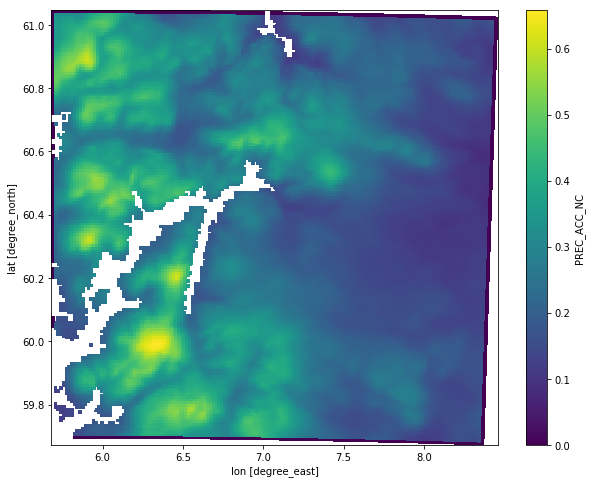

In [18]:
fig = plt.figure(figsize=(10, 8))

prc_mean.where(da_mask.values == 1).plot(x='lon', y='lat')

Further reading:
https://www.unidata.ucar.edu/blogs/developer/en/entry/wrf_goes_cf_two